# 🎯 Ensemble de Modelos
## Combinación de modelos para mejorar rendimiento

### Objetivos:
1. Implementar Voting Classifier
2. Implementar Stacking Classifier
3. Comparar ensemble vs modelos individuales
4. Evaluar si mejora el rendimiento
5. Seleccionar mejor ensemble


## 1. Importar librerías


In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Añadir src al path
sys.path.append(str(Path('../src').resolve()))

from models.ensemble import create_voting_classifier, create_stacking_classifier, compare_ensemble_vs_individual
from models.train import train_model, save_model
from models.evaluate import evaluate_model
from features.vectorization import load_vectorized_data

print("✅ Librerías importadas")


✅ Librerías importadas


## 2. Cargar datos vectorizados


In [2]:
# Cargar datos vectorizados con TF-IDF
data_dir = Path('../data/processed')
X_train_tfidf, X_test_tfidf, y_train, y_test = load_vectorized_data(data_dir, prefix='tfidf')

print(f"✅ Datos cargados:")
print(f"   Train: {X_train_tfidf.shape}")
print(f"   Test: {X_test_tfidf.shape}")
print(f"   Labels - Train: {len(y_train)}, Test: {len(y_test)}")


✅ Datos vectorizados cargados desde: ../data/processed
✅ Datos cargados:
   Train: (800, 1000)
   Test: (200, 1000)
   Labels - Train: 800, Test: 200


## 3. Entrenar modelos individuales para el ensemble


In [3]:
print("="*80)
print("ENTRENANDO MODELOS INDIVIDUALES PARA ENSEMBLE")
print("="*80)

# Entrenar los mejores modelos del baseline
individual_models = {}

# 1. SVM (mejor modelo optimizado)
print("\n🔵 Entrenando SVM...")
individual_models['SVM'] = train_model(
    'svm', X_train_tfidf, y_train,
    C=0.1, kernel='linear', class_weight='balanced'
)

# 2. Logistic Regression
print("\n🟢 Entrenando Logistic Regression...")
individual_models['Logistic Regression'] = train_model(
    'logistic', X_train_tfidf, y_train,
    C=1.0, penalty='l2', class_weight='balanced'
)

# 3. Naive Bayes
print("\n🟡 Entrenando Naive Bayes...")
individual_models['Naive Bayes'] = train_model(
    'naive_bayes', X_train_tfidf, y_train,
    alpha=1.0
)

# 4. Random Forest
print("\n🔴 Entrenando Random Forest...")
individual_models['Random Forest'] = train_model(
    'random_forest', X_train_tfidf, y_train,
    n_estimators=100, max_depth=10, class_weight='balanced'
)

print(f"\n✅ {len(individual_models)} modelos entrenados")


ENTRENANDO MODELOS INDIVIDUALES PARA ENSEMBLE

🔵 Entrenando SVM...

🟢 Entrenando Logistic Regression...

🟡 Entrenando Naive Bayes...

🔴 Entrenando Random Forest...

✅ 4 modelos entrenados


## 4. Crear Voting Classifier (Soft Voting)


In [4]:
print("="*80)
print("CREANDO VOTING CLASSIFIER (SOFT VOTING)")
print("="*80)

# Configuración de modelos para el ensemble
models_config = [
    {'name': 'svm', 'type': 'svm', 'params': {'C': 0.1, 'kernel': 'linear', 'class_weight': 'balanced'}},
    {'name': 'logistic', 'type': 'logistic', 'params': {'C': 1.0, 'penalty': 'l2', 'class_weight': 'balanced'}},
    {'name': 'naive_bayes', 'type': 'naive_bayes', 'params': {'alpha': 1.0}},
    {'name': 'random_forest', 'type': 'random_forest', 'params': {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}}
]

# Crear Voting Classifier con soft voting
voting_clf = create_voting_classifier(
    models_config,
    X_train_tfidf,
    y_train,
    voting='soft'
)

# Evaluar
print("\n" + "="*80)
print("EVALUACIÓN VOTING CLASSIFIER")
print("="*80)
results_voting = evaluate_model(
    voting_clf, X_train_tfidf, X_test_tfidf, y_train, y_test
)


CREANDO VOTING CLASSIFIER (SOFT VOTING)
✅ Voting Classifier creado con 4 modelos
   Tipo de votación: soft

EVALUACIÓN VOTING CLASSIFIER
RESULTADOS DE EVALUACIÓN

📊 MÉTRICAS EN TRAIN:
   Accuracy:  0.8862
   Precision: 0.9240
   Recall:    0.8216
   F1-score:  0.8698

📊 MÉTRICAS EN TEST:
   Accuracy:  0.7350
   Precision: 0.7671
   Recall:    0.6087
   F1-score:  0.6788

⚠️  OVERFITTING:
   Diferencia F1 (train-test): 19.10%
   ❌ Overfitting alto (>10%)

📋 Matriz de confusión (test):
[[91 17]
 [36 56]]


## 5. Crear Stacking Classifier


In [5]:
print("="*80)
print("CREANDO STACKING CLASSIFIER")
print("="*80)

# Crear Stacking Classifier
stacking_clf = create_stacking_classifier(
    models_config,
    X_train_tfidf,
    y_train,
    final_estimator=None,  # Usa LogisticRegression por defecto
    cv=5
)

# Evaluar
print("\n" + "="*80)
print("EVALUACIÓN STACKING CLASSIFIER")
print("="*80)
results_stacking = evaluate_model(
    stacking_clf, X_train_tfidf, X_test_tfidf, y_train, y_test
)


CREANDO STACKING CLASSIFIER
✅ Stacking Classifier creado con 4 modelos
   Cross-validation: 5 folds
   Estimador final: LogisticRegression

EVALUACIÓN STACKING CLASSIFIER
RESULTADOS DE EVALUACIÓN

📊 MÉTRICAS EN TRAIN:
   Accuracy:  0.9062
   Precision: 0.9109
   Recall:    0.8838
   F1-score:  0.8971

📊 MÉTRICAS EN TEST:
   Accuracy:  0.7600
   Precision: 0.7683
   Recall:    0.6848
   F1-score:  0.7241

⚠️  OVERFITTING:
   Diferencia F1 (train-test): 17.30%
   ❌ Overfitting alto (>10%)

📋 Matriz de confusión (test):
[[89 19]
 [29 63]]


## 6. Comparar Ensemble vs Modelos Individuales


In [6]:
print("="*80)
print("COMPARACIÓN: ENSEMBLE VS MODELOS INDIVIDUALES")
print("="*80)

# Comparar Voting vs individuales
comparison_voting = compare_ensemble_vs_individual(
    voting_clf,
    individual_models,
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test
)

print("\n📊 Comparación Voting Classifier vs Individuales:")
print(comparison_voting.to_string(index=False))

# Comparar Stacking vs individuales
comparison_stacking = compare_ensemble_vs_individual(
    stacking_clf,
    individual_models,
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test
)

print("\n📊 Comparación Stacking Classifier vs Individuales:")
print(comparison_stacking.to_string(index=False))


COMPARACIÓN: ENSEMBLE VS MODELOS INDIVIDUALES

📊 Comparación Voting Classifier vs Individuales:
             Modelo  F1 (test)  F1 (train)  Overfitting (%)  Accuracy (test)  Precision (test)  Recall (test)
Logistic Regression   0.720000    0.887978        16.797814            0.755          0.759036       0.684783
           Ensemble   0.678788    0.869814        19.102614            0.735          0.767123       0.608696
        Naive Bayes   0.630952    0.869081        23.812840            0.690          0.697368       0.576087
      Random Forest   0.627451    0.840000        21.254902            0.715          0.786885       0.521739
                SVM   0.485294    0.732577        24.728287            0.650          0.750000       0.358696

📊 Comparación Stacking Classifier vs Individuales:
             Modelo  F1 (test)  F1 (train)  Overfitting (%)  Accuracy (test)  Precision (test)  Recall (test)
           Ensemble   0.724138    0.897119        17.298141            0.760      

## 7. Visualización de resultados


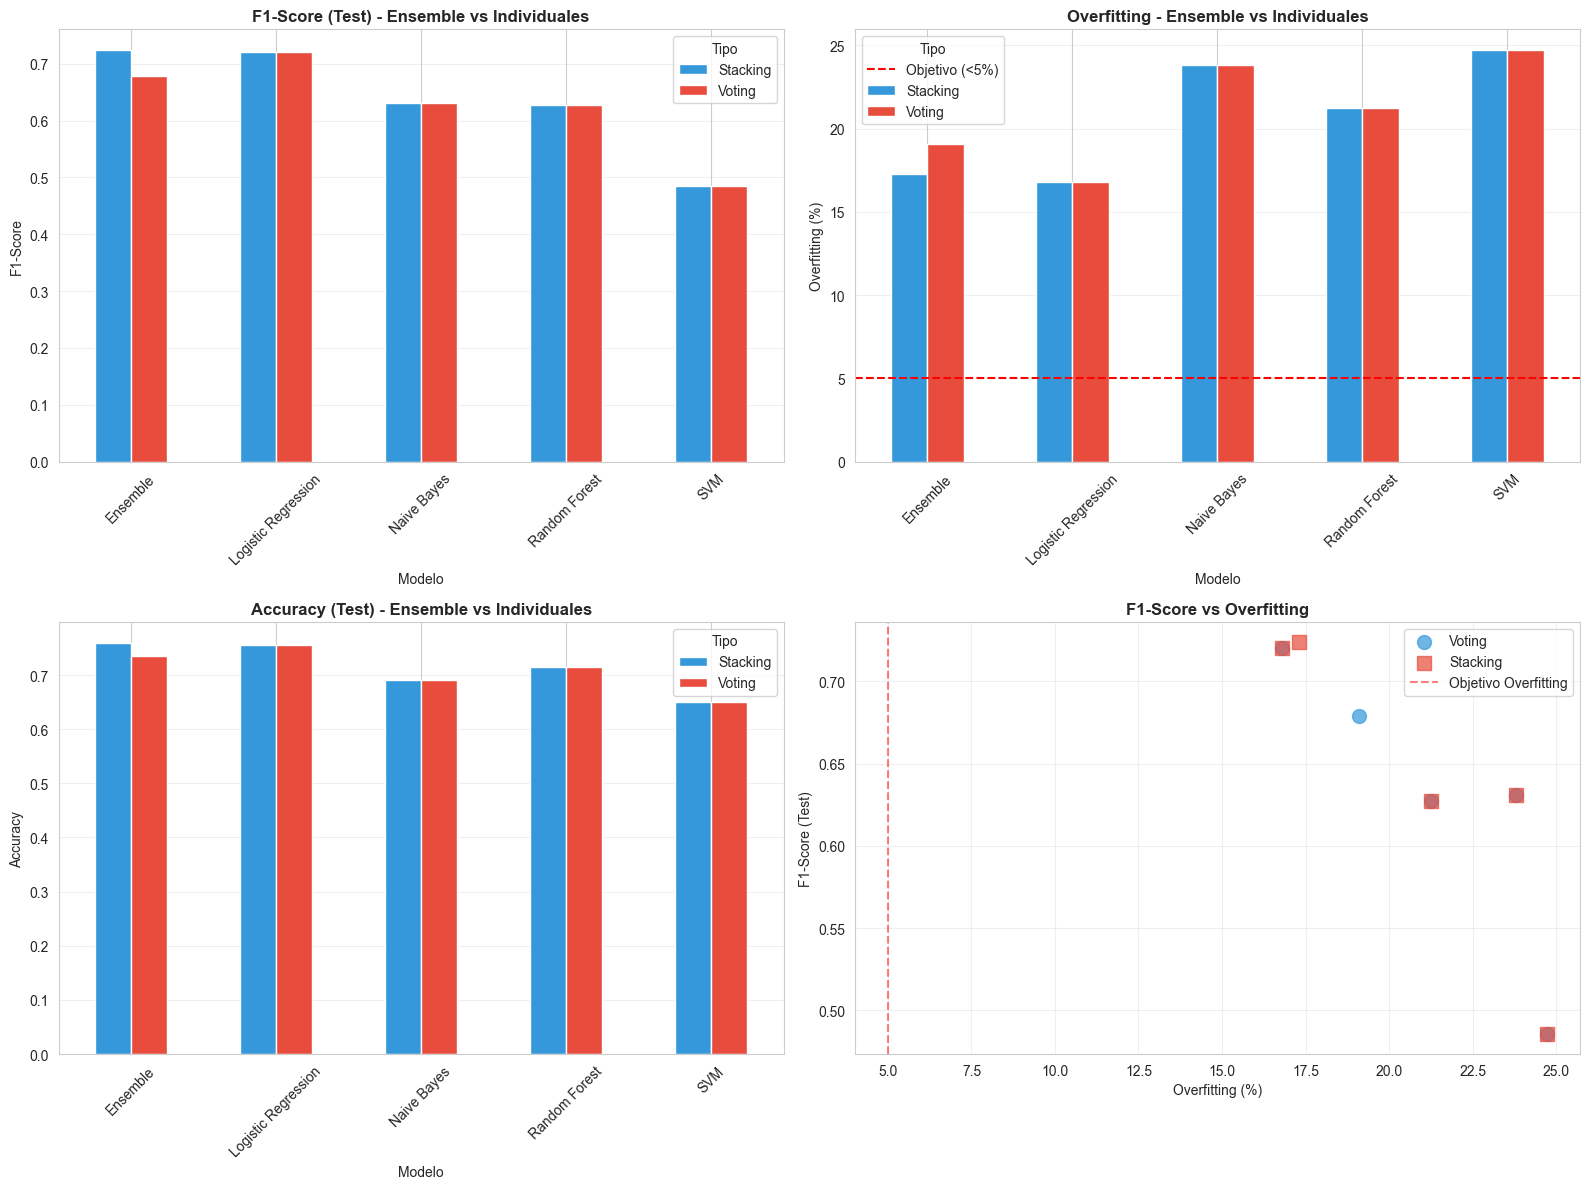

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-score comparación
comparison_all = pd.concat([
    comparison_voting.assign(Ensemble_Type='Voting'),
    comparison_stacking.assign(Ensemble_Type='Stacking')
])

# F1-score por modelo
pivot_f1 = comparison_all.pivot(index='Modelo', columns='Ensemble_Type', values='F1 (test)')
pivot_f1.plot(kind='bar', ax=axes[0, 0], color=['#3498db', '#e74c3c'])
axes[0, 0].set_title('F1-Score (Test) - Ensemble vs Individuales', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_xlabel('Modelo')
axes[0, 0].legend(title='Tipo')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Overfitting comparación
pivot_overfitting = comparison_all.pivot(index='Modelo', columns='Ensemble_Type', values='Overfitting (%)')
pivot_overfitting.plot(kind='bar', ax=axes[0, 1], color=['#3498db', '#e74c3c'])
axes[0, 1].axhline(y=5, color='r', linestyle='--', label='Objetivo (<5%)')
axes[0, 1].set_title('Overfitting - Ensemble vs Individuales', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Overfitting (%)')
axes[0, 1].set_xlabel('Modelo')
axes[0, 1].legend(title='Tipo')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Accuracy comparación
pivot_acc = comparison_all.pivot(index='Modelo', columns='Ensemble_Type', values='Accuracy (test)')
pivot_acc.plot(kind='bar', ax=axes[1, 0], color=['#3498db', '#e74c3c'])
axes[1, 0].set_title('Accuracy (Test) - Ensemble vs Individuales', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_xlabel('Modelo')
axes[1, 0].legend(title='Tipo')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Scatter: F1 vs Overfitting
axes[1, 1].scatter(
    comparison_all[comparison_all['Ensemble_Type'] == 'Voting']['Overfitting (%)'],
    comparison_all[comparison_all['Ensemble_Type'] == 'Voting']['F1 (test)'],
    label='Voting', s=100, alpha=0.7, color='#3498db', marker='o'
)
axes[1, 1].scatter(
    comparison_all[comparison_all['Ensemble_Type'] == 'Stacking']['Overfitting (%)'],
    comparison_all[comparison_all['Ensemble_Type'] == 'Stacking']['F1 (test)'],
    label='Stacking', s=100, alpha=0.7, color='#e74c3c', marker='s'
)
axes[1, 1].axvline(x=5, color='r', linestyle='--', alpha=0.5, label='Objetivo Overfitting')
axes[1, 1].set_xlabel('Overfitting (%)')
axes[1, 1].set_ylabel('F1-Score (Test)')
axes[1, 1].set_title('F1-Score vs Overfitting', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
# Comparar todos los modelos (ensembles + individuales)
all_results = {
    'Voting Classifier': results_voting,
    'Stacking Classifier': results_stacking
}

# Añadir modelos individuales
for name, model in individual_models.items():
    all_results[name] = evaluate_model(
        model, X_train_tfidf, X_test_tfidf, y_train, y_test, verbose=False
    )

# Crear comparación completa
from models.evaluate import compare_models
comparison_all = compare_models(all_results)

print("="*80)
print("COMPARACIÓN COMPLETA: TODOS LOS MODELOS")
print("="*80)
print("\n" + comparison_all.to_string(index=False))

# Seleccionar mejor modelo
good_models = comparison_all[comparison_all['Overfitting (%)'] < 5.0]

if len(good_models) > 0:
    best_model_name = good_models.iloc[0]['Modelo']
    best_model_results = all_results[best_model_name]
    print(f"\n🏆 MEJOR MODELO (Overfitting < 5%): {best_model_name}")
    print(f"   F1-score (test): {best_model_results['test_f1']:.4f}")
    print(f"   Overfitting: {best_model_results['diff_f1']:.2f}%")
    
    # Determinar qué modelo usar
    if 'Voting' in best_model_name:
        best_ensemble_model = voting_clf
        ensemble_type = 'voting'
    elif 'Stacking' in best_model_name:
        best_ensemble_model = stacking_clf
        ensemble_type = 'stacking'
    else:
        best_ensemble_model = individual_models.get(best_model_name)
        ensemble_type = 'individual'
else:
    # Si ningún modelo cumple, elegir el mejor F1
    best_model_name = comparison_all.iloc[0]['Modelo']
    best_model_results = all_results[best_model_name]
    print(f"\n⚠️  MEJOR MODELO (Overfitting > 5%): {best_model_name}")
    print(f"   F1-score (test): {best_model_results['test_f1']:.4f}")
    print(f"   Overfitting: {best_model_results['diff_f1']:.2f}%")
    
    if 'Voting' in best_model_name:
        best_ensemble_model = voting_clf
        ensemble_type = 'voting'
    elif 'Stacking' in best_model_name:
        best_ensemble_model = stacking_clf
        ensemble_type = 'stacking'
    else:
        best_ensemble_model = individual_models.get(best_model_name)
        ensemble_type = 'individual'


COMPARACIÓN COMPLETA: TODOS LOS MODELOS

             Modelo  F1 (test)  F1 (train)  Overfitting (%)  Accuracy (test)  Precision (test)  Recall (test)
Stacking Classifier   0.724138    0.897119        17.298141            0.760          0.768293       0.684783
Logistic Regression   0.720000    0.887978        16.797814            0.755          0.759036       0.684783
  Voting Classifier   0.678788    0.869814        19.102614            0.735          0.767123       0.608696
        Naive Bayes   0.630952    0.869081        23.812840            0.690          0.697368       0.576087
      Random Forest   0.627451    0.840000        21.254902            0.715          0.786885       0.521739
                SVM   0.485294    0.732577        24.728287            0.650          0.750000       0.358696

⚠️  MEJOR MODELO (Overfitting > 5%): Stacking Classifier
   F1-score (test): 0.7241
   Overfitting: 17.30%


In [9]:
# Guardar mejor ensemble si es mejor que el modelo individual
if 'Voting' in best_model_name or 'Stacking' in best_model_name:
    models_dir = Path('../models/ensemble')
    models_dir.mkdir(parents=True, exist_ok=True)
    
    model_path = models_dir / 'best_ensemble_model.pkl'
    model_info = {
        'model_name': best_model_name,
        'ensemble_type': ensemble_type,
        'vectorizer_type': 'tfidf',
        'test_f1': best_model_results['test_f1'],
        'test_accuracy': best_model_results['test_accuracy'],
        'overfitting': best_model_results['diff_f1'],
        'train_f1': best_model_results['train_f1'],
        'models_included': [config['name'] for config in models_config]
    }
    
    save_model(best_ensemble_model, model_path, model_info)
    
    print(f"\n✅ Ensemble guardado:")
    print(f"   {model_path}")
    print(f"   Información: {models_dir / 'best_ensemble_model_info.pkl'}")
else:
    print(f"\n⚠️  El mejor modelo es individual, no se guarda ensemble")


✅ Modelo guardado en: ../models/ensemble/best_ensemble_model.pkl

✅ Ensemble guardado:
   ../models/ensemble/best_ensemble_model.pkl
   Información: ../models/ensemble/best_ensemble_model_info.pkl


## 10. Resumen del ensemble


In [10]:
print("="*80)
print("RESUMEN DEL ENSEMBLE")
print("="*80)

print(f"\n✅ Ensembles implementados:")
print(f"   1. Voting Classifier (Soft Voting)")
print(f"   2. Stacking Classifier")

print(f"\n✅ Modelos incluidos en el ensemble:")
for config in models_config:
    print(f"   - {config['name']} ({config['type']})")

print(f"\n🏆 Mejor modelo:")
print(f"   {best_model_name}")
print(f"   F1-score (test): {best_model_results['test_f1']:.4f}")
print(f"   Overfitting: {best_model_results['diff_f1']:.2f}%")

# Verificar si ensemble mejora vs mejor modelo individual
best_individual = comparison_all[~comparison_all['Modelo'].str.contains('Classifier')].iloc[0]
improvement = best_model_results['test_f1'] - best_individual['F1 (test)']

if improvement > 0:
    print(f"\n📈 Mejora del ensemble vs mejor individual: +{improvement:.4f} F1-score")
else:
    print(f"\n⚠️  Ensemble no mejora vs mejor modelo individual")

print("\n✅ Ensemble completado")


RESUMEN DEL ENSEMBLE

✅ Ensembles implementados:
   1. Voting Classifier (Soft Voting)
   2. Stacking Classifier

✅ Modelos incluidos en el ensemble:
   - svm (svm)
   - logistic (logistic)
   - naive_bayes (naive_bayes)
   - random_forest (random_forest)

🏆 Mejor modelo:
   Stacking Classifier
   F1-score (test): 0.7241
   Overfitting: 17.30%

📈 Mejora del ensemble vs mejor individual: +0.0041 F1-score

✅ Ensemble completado
